In [341]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import pylab as pl
from scipy import stats
import pydotplus
import matplotlib.pyplot as plt
import seaborn as sns
import pydot
from IPython.display import display, Image

from sklearn.externals.six import StringIO
from sklearn import preprocessing
from sklearn import cluster, tree, decomposition
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
from sklearn.model_selection import train_test_split

In [342]:
df=pd.read_csv('ypedia_homepage_search_sample.csv')
pd.set_option('display.max_columns',100)
pd.set_option('max_rows', 100)
pd.set_option('display.width', 4000)

In [343]:
df.head()

,Unnamed: 0,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,channel,srch_ci,srch_co,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster
0,24636210,2014-11-03 16:02:28,24,2,77,871,36643,456.1151,792280,0,1,1,2014-12-15,2014-12-19,2,0,1,8286,1,0,1,0,63,1258,68
1,19837144,2013-03-13 19:25:01,11,3,205,135,38749,232.4737,961995,0,0,9,2013-03-13,2013-03-14,2,0,1,1842,3,0,1,2,198,786,37
2,13066459,2014-10-13 13:20:25,2,3,66,314,48562,4468.2720,495669,0,1,9,2015-04-03,2015-04-10,2,0,1,8746,1,0,1,6,105,29,22
3,4691082,2013-11-05 10:40:34,11,3,205,411,52752,171.6021,106611,0,0,0,2013-11-07,2013-11-08,2,0,1,6210,3,1,1,2,198,1234,42
4,4878884,2014-06-10 13:34:56,2,3,66,174,50644,NaN,596177,0,0,9,2014-08-03,2014-08-08,2,1,1,12812,5,0,1,2,50,368,83


In [344]:
df=df.rename(columns={'Unnamed: 0':'search_id'})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 25 columns):
search_id                    100000 non-null int64
date_time                    100000 non-null object
site_name                    100000 non-null int64
posa_continent               100000 non-null int64
user_location_country        100000 non-null int64
user_location_region         100000 non-null int64
user_location_city           100000 non-null int64
orig_destination_distance    63915 non-null float64
user_id                      100000 non-null int64
is_mobile                    100000 non-null int64
is_package                   100000 non-null int64
channel                      100000 non-null int64
srch_ci                      99878 non-null object
srch_co                      99878 non-null object
srch_adults_cnt              100000 non-null int64
srch_children_cnt            100000 non-null int64
srch_rm_cnt                  100000 non-null int64
srch_destination_id  

In [345]:
cat_list=['site_name', 'posa_continent','user_location_country', 'user_location_region',
       'user_location_city', 'channel','srch_destination_id', 'srch_destination_type_id',
        'hotel_continent', 'hotel_country', 'hotel_market','hotel_cluster']

for i in cat_list:
    print('Unique values of variable',i,':',len(df[i].unique()),'\t',list(df[i].unique())[0:10])

Unique values of variable site_name : 41 	 [24, 11, 2, 13, 28, 10, 27, 34, 53, 8]
Unique values of variable posa_continent : 5 	 [2, 3, 1, 0, 4]
Unique values of variable user_location_country : 201 	 [77, 205, 66, 3, 133, 46, 68, 119, 12, 182]
Unique values of variable user_location_region : 779 	 [871, 135, 314, 411, 174, 220, 337, 38, 20, 189]
Unique values of variable user_location_city : 10779 	 [36643, 38749, 48562, 52752, 50644, 38273, 54287, 4999, 41185, 17017]
Unique values of variable channel : 11 	 [1, 9, 0, 2, 5, 3, 7, 4, 8, 6]
Unique values of variable srch_destination_id : 8827 	 [8286, 1842, 8746, 6210, 12812, 3448, 8287, 8856, 8226, 12206]
Unique values of variable srch_destination_type_id : 8 	 [1, 3, 5, 6, 4, 8, 7, 9]
Unique values of variable hotel_continent : 7 	 [0, 2, 6, 5, 4, 3, 1]
Unique values of variable hotel_country : 178 	 [63, 198, 105, 50, 100, 144, 204, 77, 79, 8]
Unique values of variable hotel_market : 1843 	 [1258, 786, 29, 1234, 368, 582, 400, 636, 1

## Missing Value

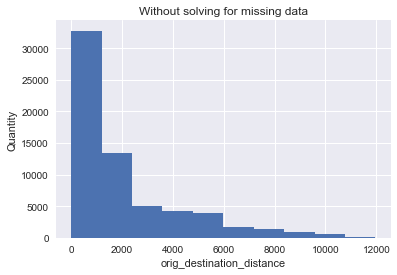

count    63915.000000
mean      1960.661721
std       2228.153377
min          0.005600
25%        312.792100
50%       1131.835300
75%       2542.359350
max      11965.376100
Name: orig_destination_distance, dtype: float64

In [346]:
# description of 'orig_destination_distance':  distance from home to destination
# description of 'Srch_ci': check-in date searched
# description of 'Srch_co': check-out date searched
## We will focus on impute the missing value of orig_desitination_distance. 
## Srch_ci and Srch_co: These two features represents dates, lets just remove them.
df['orig_destination_distance'].hist()
plt.xlabel('orig_destination_distance')
plt.ylabel('Quantity')
plt.title('Without solving for missing data')
plt.show()
df['orig_destination_distance'].describe()

There are a lot of data points missing for this feature (~36%). As we can see, mean of distance(1960) is larger than median(1131), which means that the distribution of distance is skewed. It makes sense to impute the mean of this data to the missing values, so as to minimize the difference between the mean and the median.

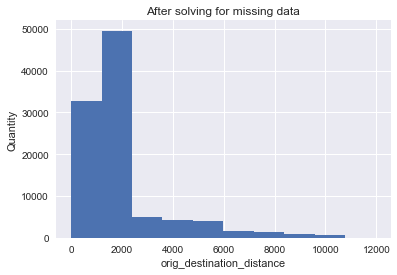

count    100000.000000
mean       1960.661721
std        1781.333573
min           0.005600
25%         745.574000
50%        1960.661721
75%        1960.661721
max       11965.376100
Name: orig_destination_distance, dtype: float64

In [347]:
df['orig_destination_distance']=df['orig_destination_distance'].fillna(df['orig_destination_distance'].mean())
df['orig_destination_distance'].hist()
plt.xlabel('orig_destination_distance')
plt.ylabel('Quantity')
plt.title('After solving for missing data')
plt.show()
df['orig_destination_distance'].describe()

## EDA

The YPedia homepage search data consists of 25 features. Since, some of the features were not used in this project, therefore those features will not be mentioned below.
The features set for this project are as follows:

User: User_id, 

content: date_time,Srch_ci,Srch_co,Srch_adults_cnt,Srch_children_cnt,Srch_room_cnt,Orig_destination_distance

method: Is_mobile,Is_package,Is_booking, channel

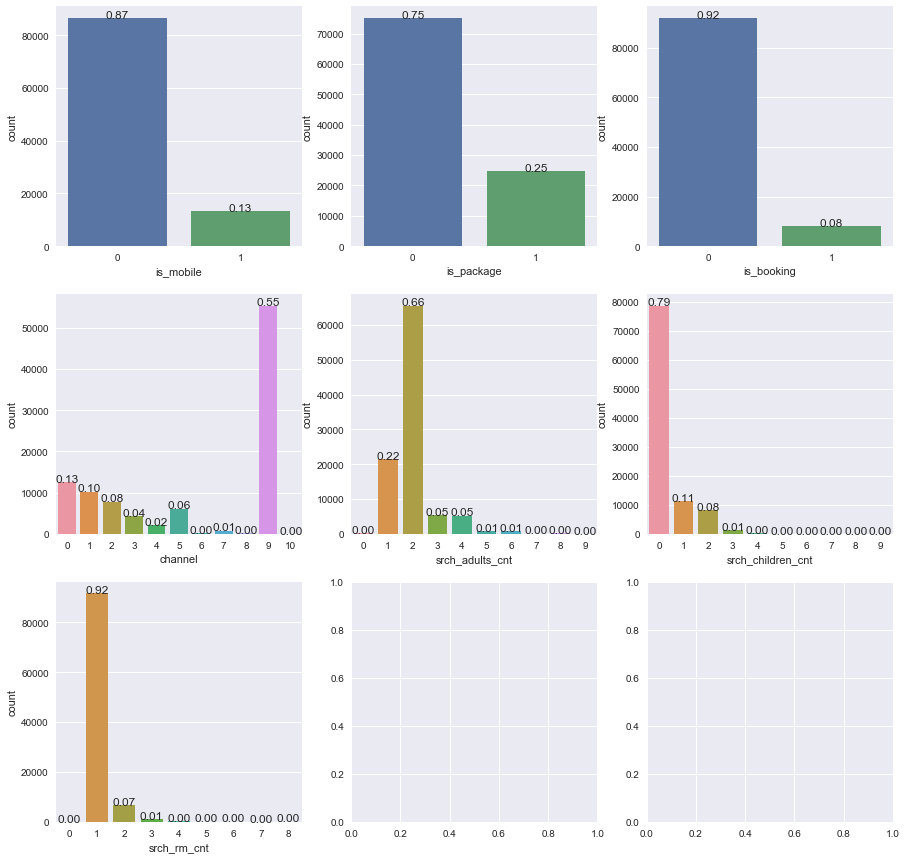

In [348]:
#1. explore categorical variables
sns.set(style="darkgrid")
fig,axs=plt.subplots(nrows=3,ncols=3,figsize=(15,15))
ax1=sns.countplot(df['is_mobile'],ax=axs[0,0])
ax2=sns.countplot(df['is_package'],ax=axs[0,1])
ax3=sns.countplot(df['is_booking'],ax=axs[0,2])
ax4=sns.countplot(df['channel'],ax=axs[1,0])
ax5=sns.countplot(df['srch_adults_cnt'],ax=axs[1,1])
ax6=sns.countplot(df['srch_children_cnt'],ax=axs[1,2])
ax7=sns.countplot(df['srch_rm_cnt'],ax=axs[2,0])
total=float(len(df))

def show_percent(axx): 
    for p in axx.patches:
        height=p.get_height()
        axx.text(p.get_x()+p.get_width()/2.,
                height+3,
                '{:1.2f}'.format(height/total),
                ha='center')
show_percent(ax1)
show_percent(ax2)
show_percent(ax3)
show_percent(ax4)
show_percent(ax5)
show_percent(ax6)
show_percent(ax7)
plt.show()

•	Is_booking: only 8% of the total searched data was converted.

•	Is_mobile: only 13% of the searched data were done by mobile apps.

•	Is_package: only 25% of the time a package was used in the search.

•	Channel: Marketing channel 9 was used the maximum number of times with 55.4%, followed by channel 0 and 1 with only 12.4% and 10.2, respectively.

•	Srch_adults_cnts: most of the time the adults count per searched results accounted for not more than 2, with 66% and 22% for 2 adults and 1 adult respectively. Followed by for 3 adults which is around 5% only.

•	Srch_children_cnt: No-children = 79%, 1 children = 11%, well this makes sense from the results we got from the adults count. They are mostly young couples with 0 or 1 children.

•	Srch_rm_cnt:91.6% of the time the room count was just 1, followed by 2 rooms for just 7%.


C:\Users\yang\Anaconda2\envs\py3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  
C:\Users\yang\Anaconda2\envs\py3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  This is separate from the ipykernel package so we can avoid doing imports until


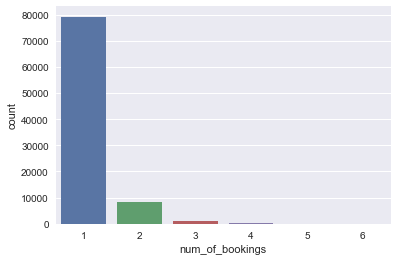

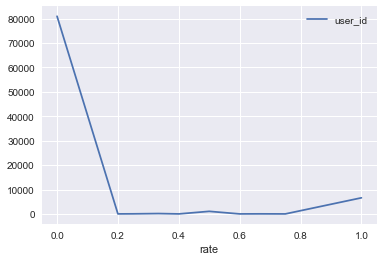

In [349]:
#2. Explore converted booking
user_book_count=df.groupby('user_id')['is_booking'].agg({'num_of_bookings':'count'}).reset_index()
user_book_rate=df.groupby('user_id')['is_booking'].agg({'rate':'mean'}).reset_index().groupby('rate')['user_id'].count().reset_index()
df=df.merge(user_book_count,on='user_id')

fig,axs=plt.subplots()
sns.countplot(user_book_count['num_of_bookings'])
user_book_rate.plot(x='rate', y='user_id')
plt.show()


In [350]:
# check data validation
## check_in date should be later than booking date
## check_out date should be later than check_in date
df['srch_co'] = pd.to_datetime(df['srch_co'])
df['srch_ci'] = pd.to_datetime(df['srch_ci'])
df['date_time'] = pd.to_datetime(df['date_time'])
df['date'] = pd.to_datetime(df['date_time'].apply(lambda x: x.date()))

def duration(row):
    delta = (row['srch_co'] - row['srch_ci'])/np.timedelta64(1, 'D')
    if delta <= 0:
        return np.nan
    else:
        return delta

def days_in_advance(row):
    delta = (row['srch_ci'] - row['date'])/np.timedelta64(1, 'D')
    if delta < 0:
        return np.nan
    else:
        return delta

df['duration'] = df.apply(duration, axis=1)
df['days_in_advance'] = df.apply(days_in_advance, axis=1)
df[['duration','days_in_advance']].describe()

,duration,days_in_advance
count,99496.000000,99853.000000
mean,3.388960,55.258360
std,3.054454,65.714297
min,1.000000,0.000000
25%,1.000000,10.000000
50%,3.000000,31.000000
75%,4.000000,76.000000
max,196.000000,497.000000


Apart from Orig_destination_distance, two more features were created.

•	Duration :  duration of stay [from the features “srch_ci” and “srch_co”]

•	Days_in_advance : number of days room searched in advance from the booking date [from features “srch_ci” and “Date_time”]

The numerical features have a lot of extreme/outlier values. Lets impute the values which exceeds 95th percentile, i.e. keep values between [0th – 95th percentile] and impute the exceeding values to the value in the 95th percentile.


In [351]:
def imputer(value,mark):
    if value> mark:
        return mark
    else:
        return value
    
dist_high=df['orig_destination_distance'].quantile(0.95)
dura_high=df['duration'].quantile(0.95)
day_in_advn_high=df['days_in_advance'].quantile(0.95)

df['orig_destination_distance']=df['orig_destination_distance'].apply(lambda x: imputer(x,dist_high))
df['duration']=df['duration'].apply(lambda x: imputer(x,dura_high))
df['days_in_advance']=df['days_in_advance'].apply(lambda x: imputer(x,day_in_advn_high))

C:\Users\yang\Anaconda2\envs\py3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\yang\Anaconda2\envs\py3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


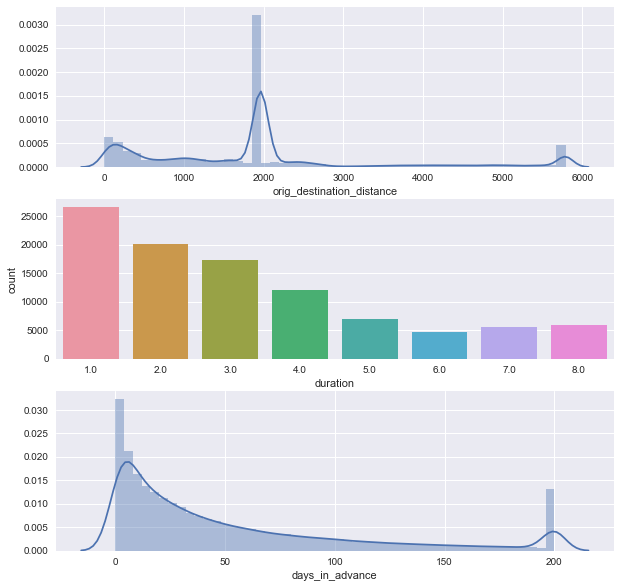

In [352]:
df2=df.copy()
df2.dropna(inplace=True)
fig,axs=plt.subplots(nrows=3,figsize=(10,10))
ax1=sns.distplot(df2['orig_destination_distance'],ax=axs[0])
ax2=sns.countplot(df2['duration'],ax=axs[1])
ax3=sns.distplot(df2['days_in_advance'],ax=axs[2])
plt.show()

## Explore Outperforming/Underperforming segments

In [353]:
#1.markeing channels
## booking rate per channel

print(df.groupby('channel')['is_booking'].agg({'booking_rate':'mean','num_of_bookings':'sum'}).reset_index().sort_values(by='booking_rate'))
print('')
print('Mean booking rate: ',df['is_booking'].mean())

    channel  booking_rate  num_of_bookings
7         7      0.043157               35
8         8      0.055351               15
3         3      0.060400              266
2         2      0.060490              474
6         6      0.067901               11
1         1      0.069690              716
0         0      0.071948              901
9         9      0.085381             4726
5         5      0.094349              581
4         4      0.120784              265
10       10      0.200000                3

Mean booking rate:  0.07993


C:\Users\yang\Anaconda2\envs\py3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.


The mean booking rate is 8%, whereas few channels have lower booking rate than the mean. Lets do a statistical test to confirm its significance.

In [354]:
def stats_comparison(df,i):
    cat = df.groupby(i)['is_booking'].agg({
            'sub_average': 'mean',
            'sub_bookings': 'count'
       }).reset_index()
        
    cat['overall_average'] = df['is_booking'].mean()
    cat['overall_bookings'] = df['is_booking'].count()
    cat['rest_bookings'] = cat['overall_bookings'] - cat['sub_bookings']
    
    cat['rest_average'] = (cat['overall_bookings']*cat['overall_average'] - cat['sub_bookings']*cat['sub_average'])/cat['rest_bookings']
    
    cat['ttest'] = (cat['sub_average']-cat['rest_average'])/np.sqrt(cat['overall_average']*(1-cat['overall_average']) * (1/cat['sub_bookings']+1/cat['rest_bookings']))
        
    cat['prob'] = np.around(stats.norm.cdf(cat.ttest), decimals = 4)
    
    cat['significant'] = [(lambda x: 'Out-performing' if x > 0.90 else 'Under-performing' if x < 0.10 else 0)(i) for i in cat['prob']]
    cat = pd.DataFrame(cat)
    cat = cat[['channel','sub_average','sub_bookings','overall_average','overall_bookings','rest_bookings',
               'rest_average','ttest','prob','significant']]
    print(cat)
    
stats_comparison(df,'channel')

C:\Users\yang\Anaconda2\envs\py3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.


    channel  sub_average  sub_bookings  overall_average  overall_bookings  rest_bookings  rest_average     ttest    prob       significant
0         0     0.071948         12523          0.07993            100000          87477      0.081073 -3.521880  0.0002  Under-performing
1         1     0.069690         10274          0.07993            100000          89726      0.081102 -4.040405  0.0000  Under-performing
2         2     0.060490          7836          0.07993            100000          92164      0.081583 -6.609924  0.0000  Under-performing
3         3     0.060400          4404          0.07993            100000          95596      0.080830 -4.888198  0.0000  Under-performing
4         4     0.120784          2194          0.07993            100000          97806      0.079014  7.135170  1.0000    Out-performing
5         5     0.094349          6158          0.07993            100000          93842      0.078984  4.307105  1.0000    Out-performing
6         6     0.067901   

1.	Sub_average :   booking rate of that particular channel.

2.	Rest_average : booking rate of all other channels combined.

3.	Ttest :  two sample t-test  value

4.	Prob :  probability obtained from Cumulative Distribution Function

5.	Significant : If the probability > 0.9, we can conclude that this particular channel outperforms other channels, i.e. we are more than 90% confident.If the probability < 0.1, we can conclude that this channel underperforms than the other channels, i.e. again we are 90% confident that it underperforms.If 0.1 <= probability <= 0.9, we cannot conclude anything statistically.


## Clustering-what are the similar user cities?

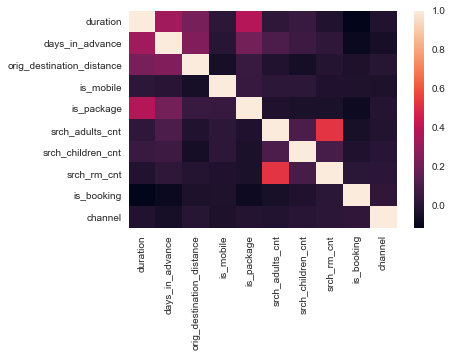

In [355]:
# Step 1: what are the features I am going to use (that make sense)?
# What features may distinguish cities? based on business sense and exploratory analysis
num_list = ['duration', 'days_in_advance', 'orig_destination_distance', 'is_mobile',
            'is_package', 'srch_adults_cnt', 'srch_children_cnt', 'srch_rm_cnt','is_booking','channel']
corr = df[num_list].corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

# Taken 0.7 as consideration, features are not correlated.

#city_data = df.dropna(axis=0)[num_list + ['user_location_city']]
#city_groups = city_data.groupby('user_location_city').mean().reset_index().dropna(axis=0)

In [356]:
# Step 2: shall I standardise the data?
# What is the magnitude of data range?
# X = city_groups.copy()
X=df[num_list].copy()
for i in num_list:
    X[i] = preprocessing.scale(X[[i]])
    
X.head()

C:\Users\yang\Anaconda2\envs\py3\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int64 were all converted to float64 by the scale function.
  
C:\Users\yang\Anaconda2\envs\py3\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int64 were all converted to float64 by the scale function.
  
C:\Users\yang\Anaconda2\envs\py3\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int64 were all converted to float64 by the scale function.
  
C:\Users\yang\Anaconda2\envs\py3\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int64 were all converted to float64 by the scale function.
  
C:\Users\yang\Anaconda2\envs\py3\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int64 were all converted to float64 by the scale function.
  
C:\Users\yang\Anaconda2\envs\py3\lib\site-packages\ipykernel_launcher.py:6: DataConve

,duration,days_in_advance,orig_destination_distance,is_mobile,is_package,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,is_booking,channel
0,0.382426,-0.182845,-0.955196,-0.392973,1.740685,-0.022764,-0.458509,-0.247454,-0.294744,-1.305089
1,0.855759,-0.413588,-0.956315,-0.392973,1.740685,-1.121943,-0.458509,-0.247454,-0.294744,0.843829
2,-1.037574,-0.928321,-1.106516,-0.392973,-0.574487,-0.022764,-0.458509,-0.247454,-0.294744,0.843829
3,1.802425,2.124579,1.759517,-0.392973,1.740685,-0.022764,-0.458509,-0.247454,-0.294744,0.843829
4,-1.037574,-0.892822,-1.147703,-0.392973,-0.574487,-0.022764,-0.458509,-0.247454,3.392779,-1.573703


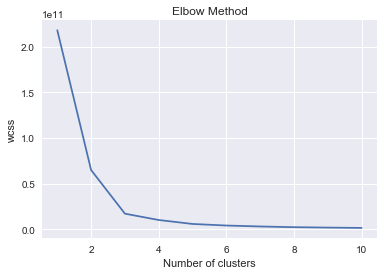

In [357]:
# Step 3: select clustering method and number of clusters
# The Elbow methods? choose a K so that the sum of the square error of the distances decrease drastically
clusters = range(1,11)
wcss = []
df.dropna(axis=0,inplace=True)

for i in clusters:
    km=KMeans(n_clusters=i)
    km.fit(df[num_list])
    wcss.append(km.inertia_)
    
plt.plot(range(1,11),wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('wcss')
plt.show()

From the WCSS (Within Cluster Sum of Squares), the first 3 clusters have large distances between them and as we move forward, the value gets minimized. So for this data, the optimal number of clusters is set to 3.


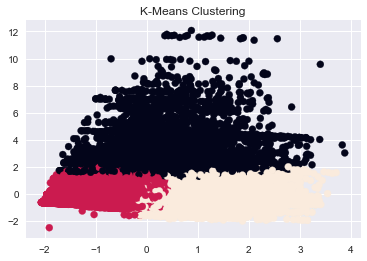

In [358]:
km = KMeans(n_clusters=3, max_iter=300, random_state=None)
X.dropna(axis=0,inplace=True)
km.fit_predict(X)
df['cluster']=km.predict(X)

# use PCA to reduce dimensions and visualize clusters
pca = decomposition.PCA(n_components=2, whiten=True)
pca.fit(X)
df['x'] = pca.fit_transform(X[num_list])[:, 0]
df['y'] = pca.fit_transform(X[num_list])[:, 1]
plt.scatter(df['x'],df['y'],c=df['cluster'])
plt.title("K-Means Clustering")
plt.show()

In [359]:
# Step 4: profile the clusters
# merging the two dataframes based on a common column user_location_city
df3=df.groupby('cluster')[num_list].mean()
print(df3)

         duration  days_in_advance  orig_destination_distance  is_mobile  is_package  srch_adults_cnt  srch_children_cnt  srch_rm_cnt  is_booking   channel
cluster                                                                                                                                                    
0        2.998986        57.499565                1801.385639   0.116599    0.172654         4.238123           0.640933     2.369351    0.077926  6.024189
1        2.119178        29.315864                1520.659168   0.125099    0.026394         1.822027           0.303090     1.016934    0.113050  5.973261
2        5.024656        89.513122                2459.753682   0.150879    0.626122         1.910096           0.331091     1.020238    0.026099  5.644455


In [360]:
# Step 5: assess the statistical robustness
# A statistically robust segmentation return similar results using different clustering methodologies
############### decision tree - what lead to a higher chance of booking for individuals? ###############

C:\Users\yang\Anaconda2\envs\py3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """


0.9170688898639754


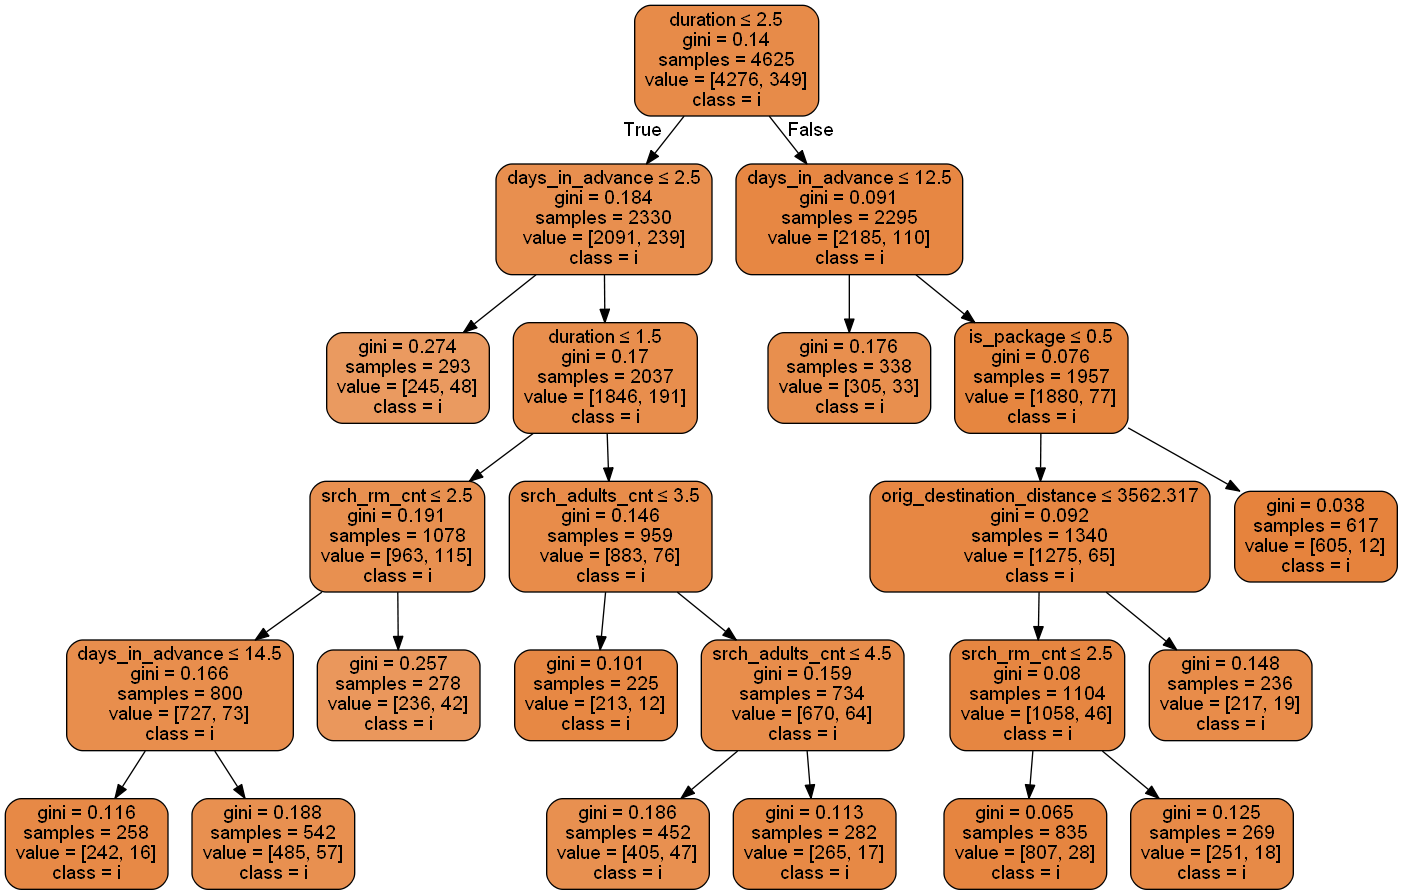

In [375]:
## cluster 0
cluster_0 = df[df['cluster'] == 0]
cluster_0_new = cluster_0.copy()
dummy_channels = pd.get_dummies(cluster_0_new['channel'], prefix='channel')
cluster_0_new = cluster_0_new.join(dummy_channels.ix[:, :])
features = ['duration','days_in_advance','orig_destination_distance','is_mobile','is_package','srch_adults_cnt',
            'srch_children_cnt','srch_rm_cnt','channel_0','channel_1','channel_2','channel_3','channel_4',
            'channel_5','channel_6','channel_7','channel_8','channel_9']
target = ['is_booking']

X=cluster_0_new[features]
y=cluster_0_new[target]

# build the decision tree model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)
clf = tree.DecisionTreeClassifier(max_leaf_nodes=12, min_samples_leaf=200)
clf=clf.fit(X_train, y_train)

# scoring of the prediction model
print(clf.score(X_test, y_test))

# visualize the decision tree
def plot_decision_tree(clf,feature_name,target_name):
    dot_data=StringIO()
    tree.export_graphviz(clf,out_file=dot_data,
                        feature_names=feature_name,
                        class_names=target_name,
                        filled=True,rounded=True,
                        special_characters=True)
    graph=pydotplus.graph_from_dot_data(dot_data.getvalue())
    return Image(graph.create_png())

plot_decision_tree(clf,X.columns,'is_booking')

C:\Users\yang\Anaconda2\envs\py3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


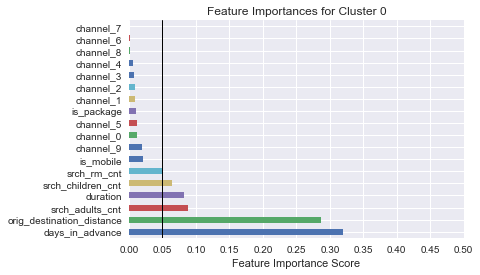

In [374]:
#What are the important features that best describes 95% of variance for each cluster?
# NOTE: The Feature Importances scores were computed using Random Forest. The black vertical line represents 95% variance in scores.
rf0 = RandomForestClassifier(n_estimators=500, random_state=0)
rf0.fit(cluster_0_new[features], cluster_0_new[target])
feat_imp = pd.Series(rf0.feature_importances_, features)
feat_imp = feat_imp.sort_values(ascending=False)
feat_imp.plot(kind='barh', title='Feature Importances for Cluster 0', rot=0)
plt.xlabel('Feature Importance Score')
plt.xticks([0.0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5])
plt.axvline(x=0.05, ymin=0.0, ymax = 1.0, linewidth=1, color='black')
plt.show()

There are 6 features that explains almost 95% of the variance.

We found out that the customers of this cluster travels an average distance of 1800 kms, books their rooms around 2 months in advance and stays 3 days in average.

Also, the probabilities of adults, children and room counts with respect to booking were good. So it makes sense that these features contributes abut 95% variance.

Whereas, the probabilities of mobile and package usage were very low, so they contribute very less.

Since, Cluster 0 mainly consists of families who travels in groups, as can be seen from the number of adults, children and room counts, we do not get any kind of information for individuals in our tree.


C:\Users\yang\Anaconda2\envs\py3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """


0.8869592509284929


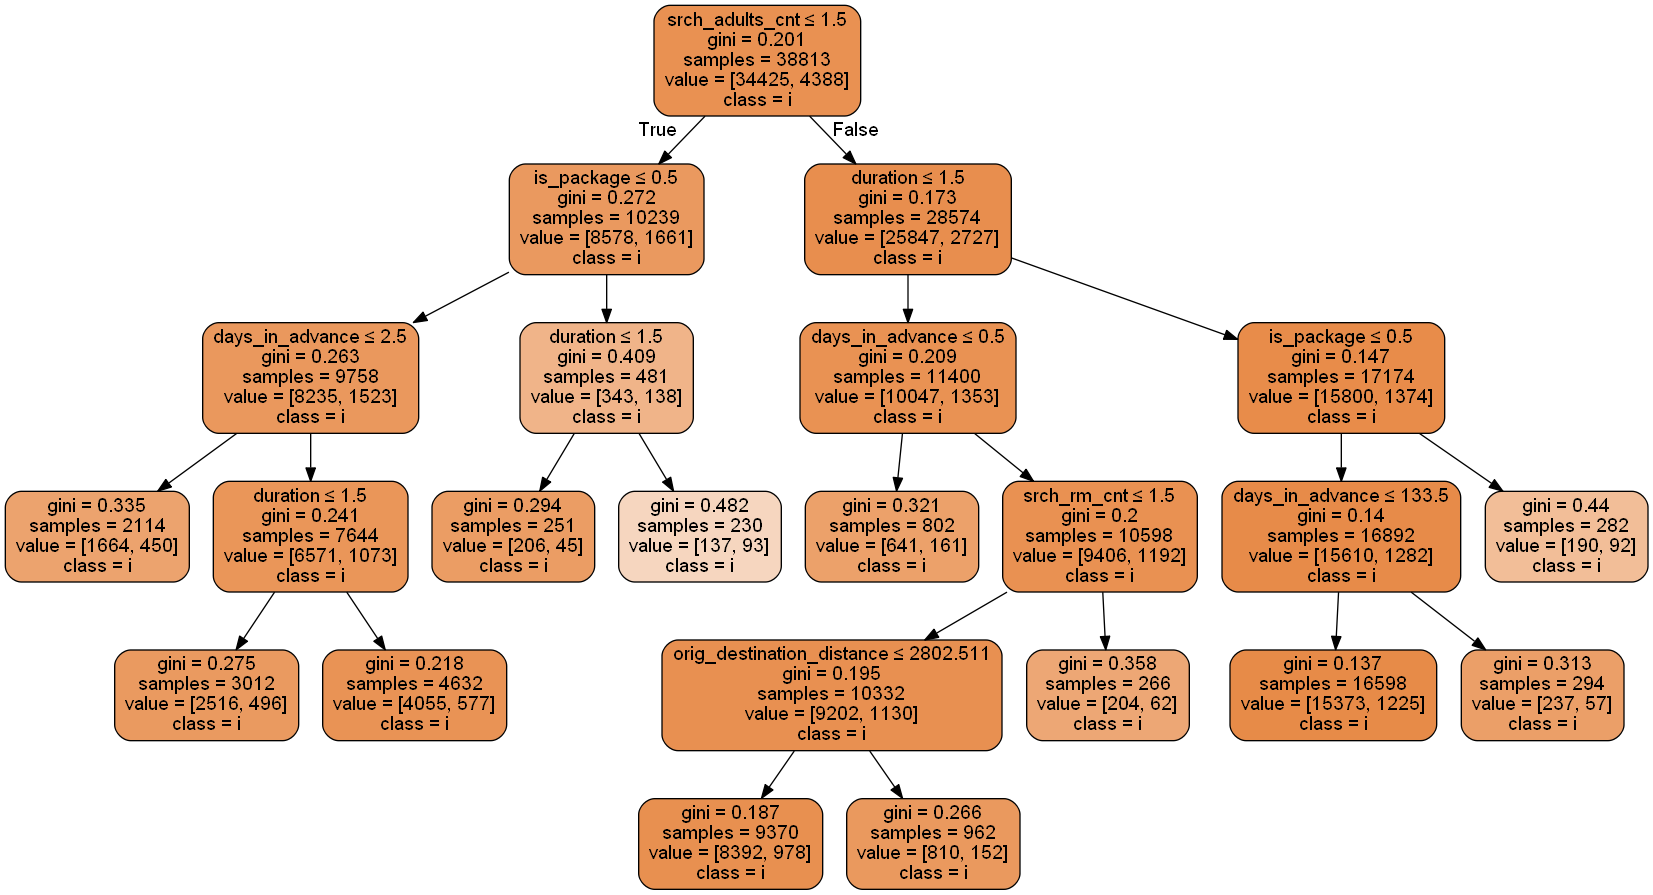

In [376]:
# cluster 1
cluster_1 = df[df['cluster'] == 1]
cluster_1_new = cluster_1.copy()
dummy_channels = pd.get_dummies(cluster_1_new['channel'], prefix='channel')
cluster_1_new = cluster_1_new.join(dummy_channels.ix[:, :])


X=cluster_1_new[features]
y=cluster_1_new[target]

# build the decision tree model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)
clf = tree.DecisionTreeClassifier(max_leaf_nodes=12, min_samples_leaf=200)
clf=clf.fit(X_train, y_train)

# scoring of the prediction model
print(clf.score(X_test, y_test))

# visualize the decision tree
plot_decision_tree(clf,X.columns,'is_booking')

C:\Users\yang\Anaconda2\envs\py3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


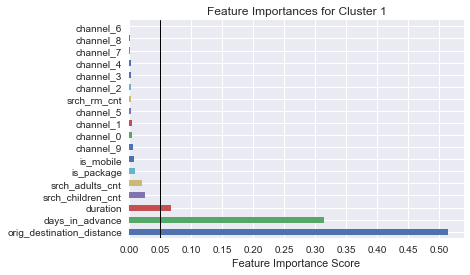

In [377]:
rf1 = RandomForestClassifier(n_estimators=500, random_state=0)
rf1.fit(cluster_1_new[features], cluster_1_new[target])
feat_imp = pd.Series(rf1.feature_importances_, features)
feat_imp = feat_imp.sort_values(ascending=False)
feat_imp.plot(kind='barh', title='Feature Importances for Cluster 1', rot=0)
plt.xlabel('Feature Importance Score')
plt.xticks([0.0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5])
plt.axvline(x=0.05, ymin=0.0, ymax = 1.0, linewidth=1, color='black')
plt.show()

C:\Users\yang\Anaconda2\envs\py3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """


0.9738430583501007


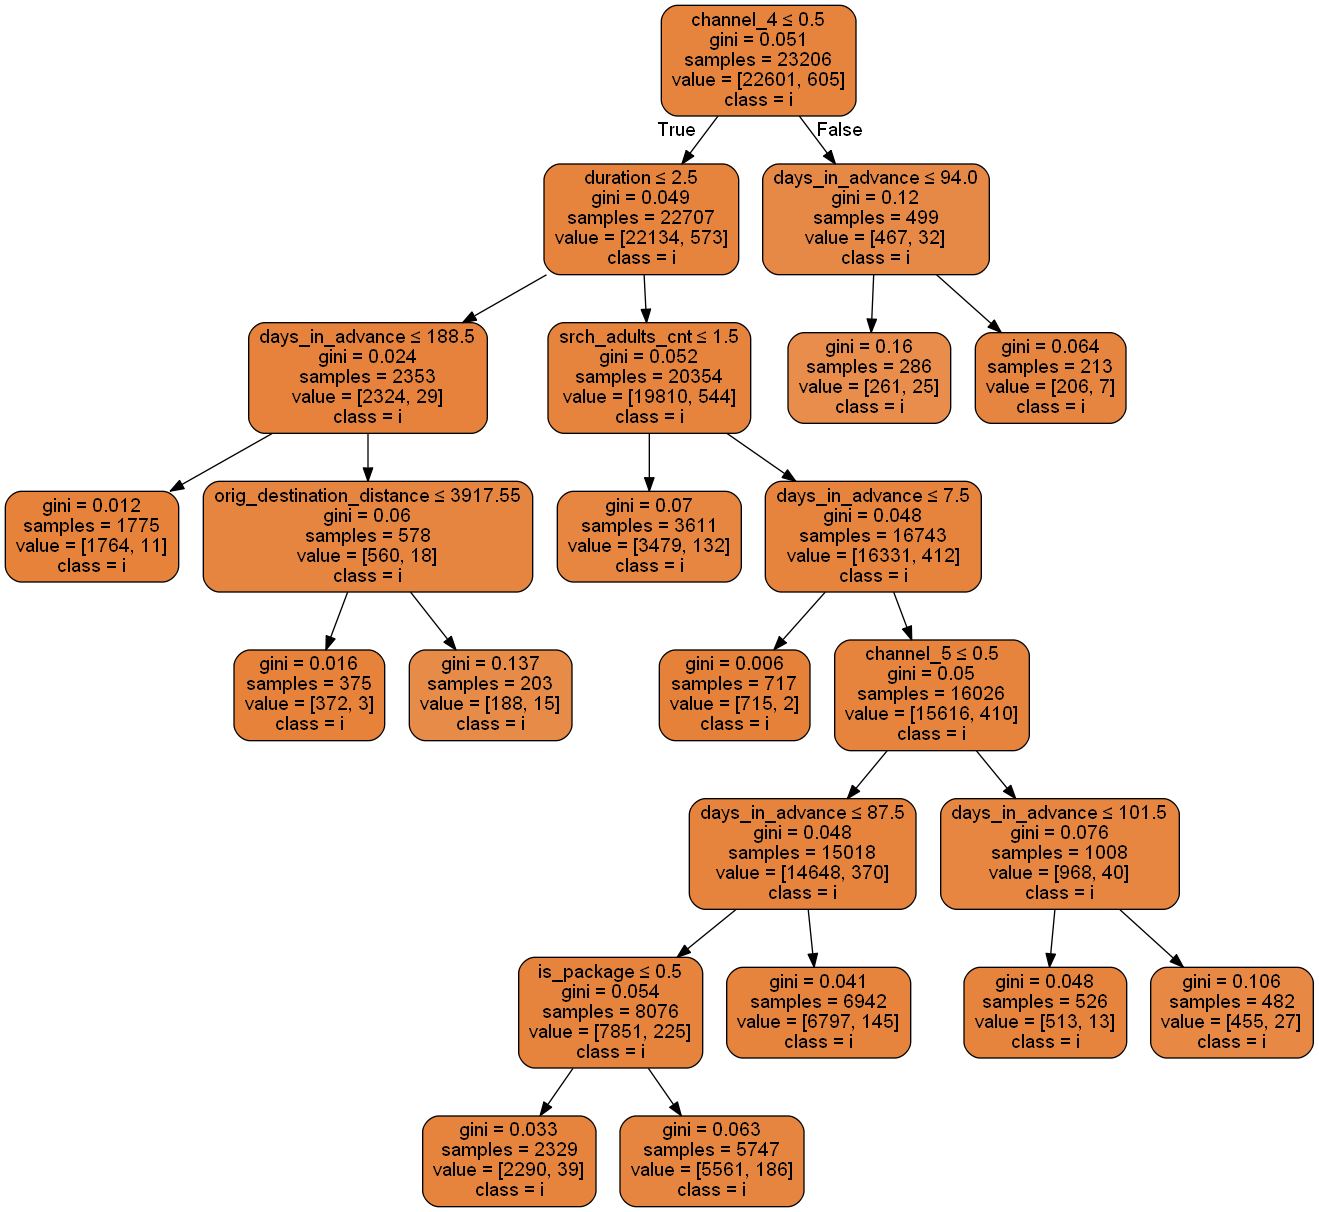

In [378]:
# cluster 2
cluster_2 = df[df['cluster'] == 2]
cluster_2_new = cluster_2.copy()
dummy_channels = pd.get_dummies(cluster_2_new['channel'], prefix='channel')
cluster_2_new = cluster_2_new.join(dummy_channels.ix[:, :])


X=cluster_2_new[features]
y=cluster_2_new[target]

# build the decision tree model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)
clf = tree.DecisionTreeClassifier(max_leaf_nodes=12, min_samples_leaf=200)
clf=clf.fit(X_train, y_train)

# scoring of the prediction model
print(clf.score(X_test, y_test))

# visualize the decision tree
plot_decision_tree(clf,X.columns,'is_booking')